# Assignment 3: 2D Multi-Element Airfoil



In [16]:
import numpy
import math
import os
from scipy import integrate, linalg
from matplotlib import pyplot

%matplotlib inline
%run ./definitions.ipynb

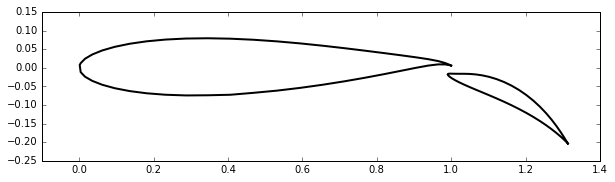

In [10]:
main_filepath = os.path.join('resources', 'MainFoil_N=50.csv')
with open (main_filepath, 'r') as file_name:
    xm, ym = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    
flap_filepath = os.path.join('resources', 'FlapFoil_N=50.csv')
with open (flap_filepath, 'r') as file_name:
    xf, yf = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

size = 10
pyplot.figure(figsize=(size, size))
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.25, 0.15)
pyplot.plot(xm, ym, xf, yf, color='k', linestyle='-', linewidth=2);

We can simply create the panels using the data we loaded because the geometry has already been discretized 

In [26]:
def define_panels(x_ends,y_ends):
    """
    Creates panels form discretized geometry.
    
    Parameters
    x: 1D array of floats
    y: 1D array of floats
    
    Returns
    -------
    panels: 1D numpy array of Panel objects
    """
    N = len(x_ends)-1
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

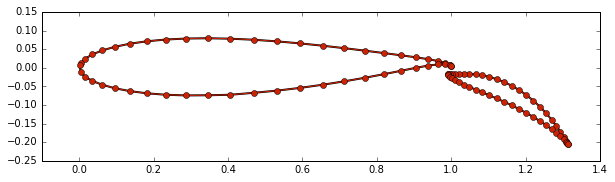

In [31]:
main_panels = define_panels(xm, ym)
flap_panels = define_panels(xf, yf)

size = 10
pyplot.figure(figsize=(size, size))
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.25, 0.15)
pyplot.plot(xm, ym, xf, yf, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in main_panels], main_panels[0].xa),
            numpy.append([panel.ya for panel in main_panels], main_panels[0].ya),
            numpy.append([panel.xa for panel in flap_panels], flap_panels[0].xa),
            numpy.append([panel.ya for panel in flap_panels], flap_panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305');

In [32]:
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf, alpha)

In [33]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float 
        x_coordinate of the target point.
    y: float
        y_coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contributions from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [34]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i!=j:
                A[i,j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc,
                                               panel_j, numpy.cos(panel_i.beta),
                                               numpy.sin(panel_i.beta))
    return A

In [35]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
        
    Returns
    -------
    A: 2D numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i!=j:
                A[i,j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc,
                                               panel_j, numpy.sin(panel_i.beta),
                                               -numpy.cos(panel_i.beta))
    return A